## 音の長さとかチェックしたい

In [3]:
!pip install torch==1.6.0
!pip install opencv-python
!pip install torchvision==0.2.2
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 748.8 MB 16 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 49.5 MB 29.4 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 64 kB 5.6 MB/s 
     |████████████████████████████████| 52 kB 3.7 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user i

In [76]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
# import resnest.torch as resnest_torch

from torchvision import models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from resnet import ResNet, Bottleneck

from albumentations.core.transforms_interface import DualTransform, BasicTransform
import albumentations as albu

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## util

In [77]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
set_seed(100)

In [78]:
INPUT_ROOT = Path("/home/knikaido/work/Rainforest-Connection/data")
RAW_DATA = INPUT_ROOT / "rfcx-species-audio-detection"
TRAIN_AUDIO_DIR = RAW_DATA / "train_denoise"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test"

In [79]:
train = pd.read_csv(RAW_DATA / "train_tp.csv")
train['tp'] = 1
train_fp = pd.read_csv(RAW_DATA / "train_fp.csv")
train_fp['tp'] = 0
whole = pd.concat([train, train_fp])

In [80]:
wav_pathes = sorted(glob.glob(str(TRAIN_AUDIO_DIR / '*.flac')))
len(wav_pathes)

4727

In [81]:
y, sr = sf.read(wav_pathes[0])

In [82]:
from stft import Spectrogram, LogmelFilterBank
        # Spectrogram extractor
spectrogram_extractor = Spectrogram(n_fft=2048, hop_length=512, 
    win_length=2048, window='hann', center=True, pad_mode='reflect', 
    freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sr, n_fft=2048, 
    n_mels=384, fmin=40, fmax=24000, ref=1.0, amin=1e-10, top_db=None, 
    freeze_parameters=True)

In [83]:
torch_y = torch.from_numpy(y.astype(np.float32)).clone()
torch_y = torch_y.reshape(1, -1)
spectro = spectrogram_extractor(torch_y)
# batch_size x 1 x time_steps x freq_bins
mel_torch = logmel_extractor(spectro)

In [84]:
mel_from_torch = mel_torch.to('cpu').detach().numpy().copy()
mel_from_torch = mel_from_torch.reshape(mel_from_torch.shape[2], mel_from_torch.shape[3])
mel_from_torch.shape

(5626, 384)

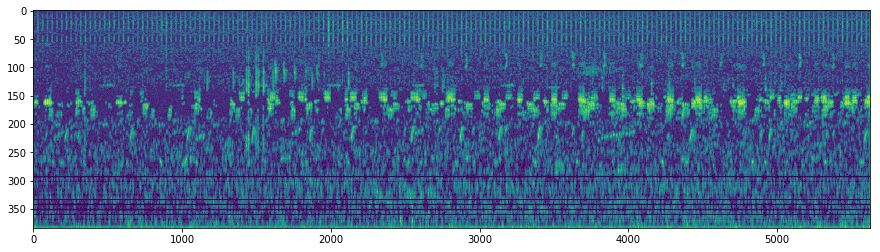

In [85]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_from_torch.T))
plt.axes().set_aspect('auto')

In [86]:
spectro[0][0].T

tensor([[1.3184e+00, 1.1988e+00, 9.8736e-01,  ..., 5.4518e-06, 1.2068e-03,
         4.5776e-02],
        [3.2390e-01, 3.2765e-01, 2.7621e-01,  ..., 2.8111e-02, 3.8714e-02,
         5.1999e-02],
        [1.4810e-02, 2.1614e-02, 2.0964e-02,  ..., 9.7885e-02, 7.0740e-02,
         8.5007e-04],
        ...,
        [2.0667e-03, 5.8569e-04, 2.5559e-05,  ..., 1.7097e-04, 6.2360e-05,
         8.3335e-06],
        [1.6061e-03, 1.0364e-03, 3.9575e-04,  ..., 7.3437e-04, 5.3168e-04,
         4.6909e-04],
        [7.5759e-04, 3.9427e-06, 6.4641e-04,  ..., 1.7872e-03, 2.1654e-03,
         1.8238e-03]])

In [87]:
melW = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=384,
            fmin=40, fmax=24000)
stft = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) ** 2
mel_ = np.dot(melW, stft)

In [88]:
mel_ = librosa.power_to_db(mel_).astype(np.float32)

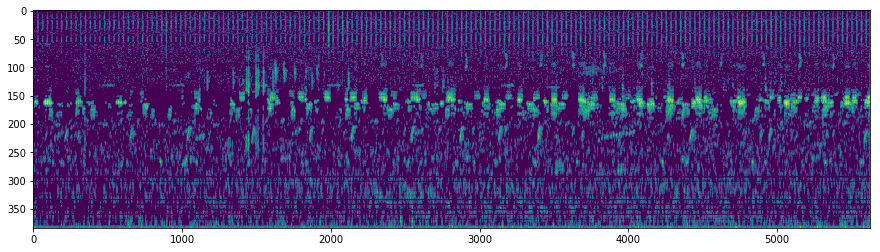

In [89]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_))
plt.axes().set_aspect('auto')

In [105]:
images = mel_
images = images - images.min()
r = random.randint(384//2,384)
x = random.random()/2
pink_noise = np.array([np.concatenate((1-np.arange(r)*x/r,np.zeros(384-r)-x+1))]).T
images = images*pink_noise
images = images/images.max()

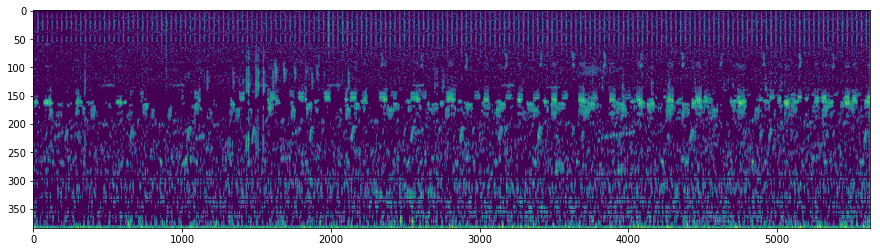

In [106]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(images))
plt.axes().set_aspect('auto')

In [26]:
chroma = librosa.filters.chroma(sr=sr, n_fft=2048, n_chroma=384)
stft = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) ** 2
chroma_ = np.dot(chroma, stft)

In [28]:
chroma_ = librosa.power_to_db(chroma_).astype(np.float32)

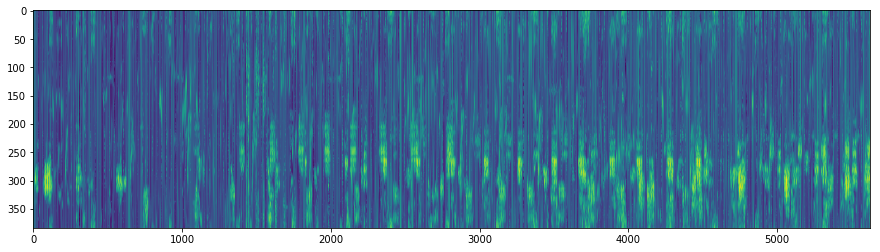

In [29]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(chroma_))
plt.axes().set_aspect('auto')

In [50]:
!pip install git+https://github.com/SiggiGue/pyfilterbank.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/SiggiGue/pyfilterbank.git to /tmp/pip-req-build-68l_gbsn
  Running command git clone -q https://github.com/SiggiGue/pyfilterbank.git /tmp/pip-req-build-68l_gbsn
  Created wheel for pyfilterbank: filename=pyfilterbank-0.0.0-py3-none-any.whl size=67061 sha256=267d722c0a4bb9adae6a44151352cc4a26566376e8444c0fceb73b1cfaffa2ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-ux9p898q/wheels/c4/d3/7b/820929bb81dcfe92320c3aaf045e800ed708bb9538bbc17eae
Successfully built pyfilterbank


In [67]:
from pyfilterbank import melbank, gammatone

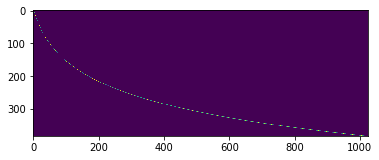

In [63]:
melW_ = melbank.compute_melmat(num_mel_bands=384, freq_min=40, freq_max=24000, num_fft_bands=1025, sample_rate=sr)[0]
plt.imshow(melW_)

In [65]:
melW_ = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=384,
            fmin=40, fmax=24000)
stft = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) ** 2
mel_ = np.dot(melW_, stft)

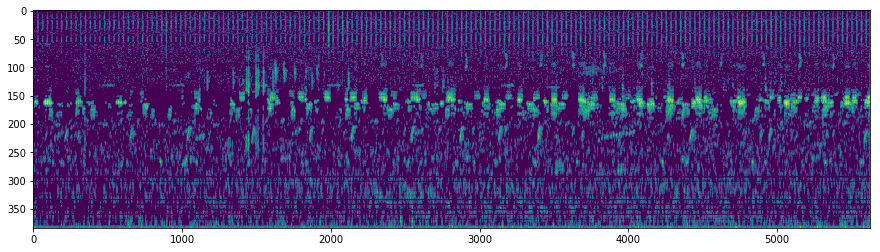

In [66]:
mel_ = librosa.power_to_db(mel_).astype(np.float32)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_))
plt.axes().set_aspect('auto')

In [75]:
gammatone.GammatoneFilterbank(samplerate=sr, order=4, startband=-12, endband=12, normfreq=1000.0, density=1.0, bandwidth_factor=1.0, desired_delay_sec=0.02)

In [21]:
melspec = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, n_mels=384,
            fmin=40, fmax=24000)
melspec = librosa.power_to_db(melspec).astype(np.float32)
melspec.shape

(384, 5626)

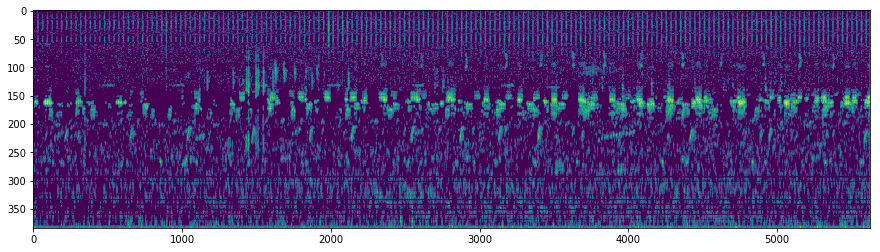

In [22]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(melspec))
plt.axes().set_aspect('auto')

In [70]:
train[train['recording_id'] == wav_num]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
3,0099c367b,17,4,51.4206,1464.26,55.1996,4565.04


In [63]:
train['recording_id'][0]

'003bec244'

In [64]:
for path in tqdm(wav_pathes):
    if(train['recording_id'][0] in path):
        print(path)
        break

  0%|          | 0/4727 [00:00<?, ?it/s]

/home/knikaido/work/Rainforest-Connection/data/rfcx-species-audio-detection/train/003bec244.flac


In [ ]:
for i in range(len(wav_pathes)):
    wav_num = wav_pathes[0].split('/')[-1].split('.')[0]

train_csvにないwavもある！これをどうtrainにつかおうかしら．→ノートブックを確認してみる

In [78]:
np.min(whole['f_min'])

93.75

In [77]:
np.max(whole['f_max'])

13687.5

In [36]:
from gammatone.gammatone import gtgram

In [54]:
result = gtgram.gtgram(y, fs=sr, window_time=2048/sr, hop_time=512/sr, channels=128*3, f_min=40)

In [55]:
result.shape

(384, 5622)

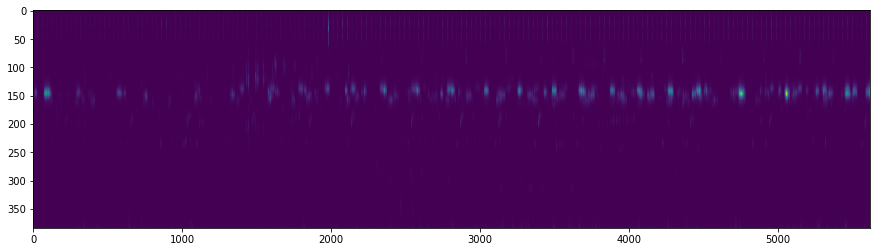

In [56]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(result))
plt.axes().set_aspect('auto')

In [53]:
result

array([[3.19143540e-04, 3.29026720e-04, 2.68986700e-04, ...,
        1.36824763e-04, 1.71331349e-04, 2.35598200e-04],
       [2.89343078e-04, 3.00770691e-04, 2.54375200e-04, ...,
        1.34270271e-04, 1.71395827e-04, 2.46582849e-04],
       [2.65912003e-04, 2.79600250e-04, 2.49064492e-04, ...,
        1.30706303e-04, 1.69069583e-04, 2.47963533e-04],
       ...,
       [1.95903909e-04, 1.15639626e-04, 5.80959445e-05, ...,
        4.35880826e-05, 7.69110428e-05, 1.18501716e-04],
       [1.64219265e-04, 9.37988541e-05, 4.83581229e-05, ...,
        3.93980275e-05, 6.92785581e-05, 1.02975511e-04],
       [1.40795409e-04, 7.89735532e-05, 4.16710571e-05, ...,
        3.51863153e-05, 6.17833300e-05, 9.02445746e-05]])